# 🔍 Classificazione Tossicità Chat con modelli ML

Questo notebook implementa **3 approcci di tokenizzazione ottimizzati** per la classificazione di tossicità in chat italiane con **grid search automatica** per ottimizzazione degli iperparametri.

## 📋 Caratteristiche:
- **Tokenizer**: SpaCy Base, SpaCy con Stemming NLTK, SpaCy con Preprocessing Avanzato
- **Pipeline ML**: Logistic Regression + TF-IDF, Naive Bayes + CountVectorizer  
- **Focus principale**: **Recall Toxic** (label 0) - metrica cruciale per identificare contenuti tossici
- **Validazione**: 3-fold stratified cross-validation + test set finale (80/20 split)
- **Metriche**: Accuracy, F1-score, Precision, Recall per ogni classe + **Confusion Matrix Heatmap**
- **Ottimizzazioni**: Caching tokenizer, pipeline SpaCy ridotta, grid search automatica, gestione encoding UTF-8

## 🎯 Obiettivi:
- Confrontare performance di tokenizzazione avanzata vs. baseline semplici
- **Minimizzare errori critici** (Toxic→Neutral/Healthy) attraverso ottimizzazione Recall Toxic
- Valutare impatto ottimizzazioni su velocità e accuracy  
- Analizzare efficacia preprocessing e stemming per classificazione tossicità
- Fornire raccomandazioni per uso in produzione con parametri ottimali

## 🚀 Struttura:
1. **Setup & Configurazione** (celle 1-4)
2. **Tokenizer Definitions & Caching** (celle 4.1-4.2.2) 
3. **Grid Search Experiments** (celle 8.1-8.3.3)
   - 8.2: Logistic Regression + TF-IDF (3 tokenizer variants)
   - 8.3: Naive Bayes + CountVectorizer (3 tokenizer variants)
4. **Confronto Risultati & Salvataggio** (cella 9)

## ⚙️ Configurazioni Dataset:
- **Labels**: Toxic (0), Neutral (1), Healthy (2)
- **Soglie polarità**: [-1.00, -0.35] = Toxic, [-0.35, 0.35] = Neutral, [0.35, 1.00] = Healthy
- **Output**: Dataset processato salvato in `../rsc/dataset_toxicity_classification.csv`
- **Risultati**: Grid search salvati in `../gs_results/` con timestamp

## 🔧 Tokenizer Implementati:

### 1. **SpaCy Base** 
- Tokenizzazione base senza preprocessing
- Cache abilitata per performance

### 2. **SpaCy + Stemming NLTK**
- Stemming italiano con SnowballStemmer
- Normalizzazione morfologica delle parole

### 3. **SpaCy + Preprocessing Avanzato**
- **Whitelist**: Solo token alfabetici + emoji
- **Stopwords removal** (italiano)
- **Lemmatizzazione** + case normalization
- **Preserva maiuscole** per enfasi/urgenza
- **Mantiene emoji** come indicatori emotivi

## 📊 Grid Search Parameters:

### TF-IDF + Logistic Regression:
- `ngram_range`: (1,2), (1,3), (1,4)
- `min_df`: 3, 8, 20
- `max_df`: 0.9, 0.95, 0.99
- `C`: 0.1, 1.0, 10.0
- `max_iter`: 1000, 2000

### CountVectorizer + Naive Bayes:
- `ngram_range`: (1,2), (1,3), (1,4)
- `min_df`: 3, 8, 20
- `max_df`: 0.9, 0.95, 0.99
- `alpha`: 0.1, 0.5, 1.0, 2.0

## 🎯 Metriche Critiche:
- **Test Recall Toxic**: Percentuale di contenuti tossici correttamente identificati
- **Errori Critici**: Toxic→Neutral, Toxic→Healthy (falsi negativi pericolosi)
- **CV Accuracy**: Performance media su cross-validation
- **Confusion Matrix**: Visualizzazione errori per classe

## ⏱️ Performance Tempi:
- **~300 campioni**: 2-4 minuti per grid search
- **~1400 campioni**: 6-17 minuti per grid search
- **Caching attivo**: Significativa riduzione tempi su run multiple

## 1. 📦 Importazione Librerie e Configurazioni

In [5]:
# Importazioni principali
import re
import os
from typing import List, Tuple

import pandas as pd
import matplotlib.pyplot as plt
import tqdm

# Importazioni scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, recall_score, confusion_matrix
import seaborn as sns

# Importazioni NLP
from nltk.stem.snowball import SnowballStemmer
import emoji  # Per gestire le emoji
import spacy

### 1.1 ⚙️ Configurazioni Globali

In [6]:
# Dataset path
DATASET_PATH = "../rsc/chats_dataset"

OUTPUT_CSV_PATH = "../rsc/dataset_toxicity_classification.csv"

# Configurazioni classificazione
POLARITY_BINS = [-1.00, -0.35, 0.35, 1.00]
POLARITY_LABELS = [0, 1, 2]
TARGET_NAMES = ['Toxic', 'Neutral', 'Healthy']

# Regex per parsing messaggi
MSGS_REGEX = re.compile(
    r"(?P<message>(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}) \| (?P<name>.+):\n"
    r"(?P<content>.+)\nPolarity: (?P<polarity>(?P<sign>-?|\+?)\d\.?\d?\d?)\n"
    r"\[(?P<tag_explanation>(?P<tag>Tag: .+)\n?(?P<explanation>Spiegazione: .+))\])"
)

print(f"   📂 Dataset path: {DATASET_PATH}")

   📂 Dataset path: ../rsc/chats_dataset


## 2. 🛠️ Funzioni di utility

In [7]:
def get_dataset_path():
    """Verifica esistenza dataset."""
    if os.path.exists(DATASET_PATH):
        print(f"✅ Dataset trovato: {os.path.abspath(DATASET_PATH)}")
        return DATASET_PATH
    else:
        raise FileNotFoundError(f"❌ Dataset non trovato: {DATASET_PATH}")

# Test utility functions
try:
    dataset_path = get_dataset_path()
except Exception as e:
    print(f"⚠️ Errore utility: {e}")


def plot_polarity_distribution(df: pd.DataFrame) -> None:
    """Crea un istogramma della distribuzione delle polarità."""
    plt.figure(figsize=(10, 6))
    df["avg_polarity"].hist(edgecolor='black', alpha=0.7, bins=POLARITY_BINS[:-1] + [POLARITY_BINS[-1]])
    plt.xticks(POLARITY_BINS)
    plt.xlabel('Average Polarity')
    plt.ylabel('Frequency')
    plt.title('Distribution of Average Polarity')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_confusion_matrix_heatmap(y_true, y_pred, target_names, title="Confusion Matrix"):
    """Crea heatmap della confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(9, 7))  # Aumenta dimensioni per più spazio
    sns.heatmap(cm, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=target_names,
                yticklabels=target_names,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 12})
    
    plt.title(f'{title}\nAccuracy: {(cm.diagonal().sum() / cm.sum()):.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()

✅ Dataset trovato: c:\Users\tomma\Desktop\cipv-assistant\rsc\chats_dataset


## 3. 📂 Caricamento e Parsing Dataset

✅ Dataset trovato: c:\Users\tomma\Desktop\cipv-assistant\rsc\chats_dataset
📂 Caricamento dati da: ../rsc/chats_dataset


Processing chats: 100%|██████████| 50/50 [00:09<00:00,  5.53it/s]



📊 Chat valide trovate: 1767
2 campioni con label NaN:
                                             chat_text  avg_polarity label
625  Elena. Ricordi quelle foto che mi hai mandato ...          -1.0   NaN
785  Non pensare di aver chiuso la questione con qu...          -1.0   NaN

📊 Dataset dopo rimozione NaN: 1765 campioni

Distribuzione delle label:
label
0    724
1    570
2    471
Name: count, dtype: int64

💾 Salvando dataset in: ../rsc/dataset_toxicity_classification.csv
Training: 1412 | Test: 353


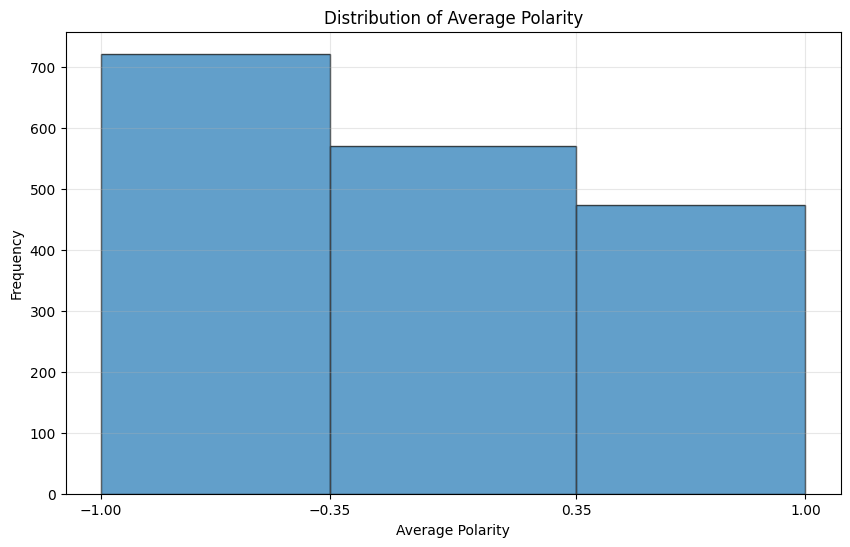

In [8]:
def load_and_parse_chats(dataset_path: str) -> List[Tuple[str, float]]:
    """Carica e analizza i file di chat dal dataset."""
    print(f"📂 Caricamento dati da: {dataset_path}")
    
    chats = []
    dirs = os.listdir(dataset_path)
    
    for directory in tqdm.tqdm(dirs, desc="Processing chats"):
        directory_path = os.path.join(dataset_path, directory)
        if not os.path.isdir(directory_path):
            continue
            
        for file in os.listdir(directory_path):
            file_path = os.path.join(directory_path, file)
            try:
                with open(file_path, "r", encoding="utf-8") as f:
                    content = f.read()
                    matches = list(MSGS_REGEX.finditer(content))
                    
                    if matches:
                        chat_text = '\n'.join([match.group("content") for match in matches])
                        avg_polarity = sum(float(match.group("polarity")) for match in matches) / len(matches)
                        chats.append((chat_text, avg_polarity))
            except Exception:
                continue
    
    print(f"📊 Chat valide trovate: {len(chats)}")
    return chats

def prepare_dataset():
    """Prepara il dataset per il training."""
    dataset_path = get_dataset_path()
    chats = load_and_parse_chats(dataset_path)
    
    # Crea DataFrame
    df = pd.DataFrame(chats, columns=["chat_text", "avg_polarity"])
    df["label"] = pd.cut(df["avg_polarity"], bins=POLARITY_BINS, labels=POLARITY_LABELS)

    nan = df[df['label'].isna()]
    print(len(nan), "campioni con label NaN:")
    print(nan)
    df = df.dropna(subset=['label'])

    print(f"\n📊 Dataset dopo rimozione NaN: {len(df)} campioni")
    print(f"\nDistribuzione delle label:")
    print(df["label"].value_counts())

    # Salva il dataset e mostra la distribuzione
    print(f"\n💾 Salvando dataset in: {OUTPUT_CSV_PATH}")
    df.to_csv(OUTPUT_CSV_PATH, index=False)

    
    
    # Split dati
    X_train, X_test, y_train, y_test = train_test_split(
        df['chat_text'], df['label'], 
        test_size=0.2, 
        random_state=42, 
        stratify=df['label']
    )
    
    print(f"Training: {len(X_train)} | Test: {len(X_test)}")
    
    return df, X_train, X_test, y_train, y_test

# Carica dataset
df, X_train, X_test, y_train, y_test = prepare_dataset()

plot_polarity_distribution(df)

## 4. 🔤 Definizione Tokenizer

### 4.1 🔤 Tokenizer SpaCy con caching e pipeline ridotta per velocizzare il training: 
- Implementato sistema di caching che evita di ricalcolare i token per i sample già analizzati nella stessa sessione.
- Componenti del tokenizer non necessarie disabilitate.

In [9]:
nlp = spacy.load("it_core_news_sm")
print("🚀 Disabilitazione componenti non necessari per velocizzare la pipeline...")
print(" Componenti attivi nella pipeline standard: ", nlp.pipe_names)
nlp.disable_pipes(*[name for name in nlp.pipe_names if name != "lemmatizer"])
print(" Componenti attivi dopo disabilitazione: ", nlp.pipe_names)

🚀 Disabilitazione componenti non necessari per velocizzare la pipeline...
 Componenti attivi nella pipeline standard:  ['tok2vec', 'morphologizer', 'tagger', 'parser', 'lemmatizer', 'attribute_ruler', 'ner']
 Componenti attivi dopo disabilitazione:  ['lemmatizer']


#### 4.2.1 🔤 Tokenizer SpaCy base (no preprocessing)

In [10]:
_spacy_base_doc_cache = {}
def Spacy_tokenizer_base(text: str) -> List[str]:
    """Tokenizza con SpaCy base"""
    # Cache dei documenti: controlla se già processato
    text_hash = hash(text)
    if text_hash in _spacy_base_doc_cache:
        return _spacy_base_doc_cache[text_hash]

    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(token.text)

    # Salva in cache (limita dimensione cache)
    if len(_spacy_base_doc_cache) < 1000:
        _spacy_base_doc_cache[text_hash] = tokens
    
    return tokens

#### 4.2 🔤 Tokenizer Spacy con Stemmer (NLTK)

In [11]:
stemmer = SnowballStemmer("italian")

_spacy_stemmer_doc_cache = {}
def Spacy_tokenizer_with_stemming(text: str) -> List[str]:
    """Spacy Tokenizer con Stemming NLTK."""

    # Cache dei documenti: controlla se già processato
    text_hash = hash(text)
    if text_hash in _spacy_stemmer_doc_cache:
        return _spacy_stemmer_doc_cache[text_hash]

    doc = nlp(text)
    tokens = []
    for token in doc:
        tokens.append(stemmer.stem(token.text))

    # Salva in cache (limita dimensione cache)
    if len(_spacy_stemmer_doc_cache) < 1000:
        _spacy_stemmer_doc_cache[text_hash] = tokens
    
    return tokens

#### 4.2.2 🔤 Tokenizer SpaCy base con preprocessing

Preprocessing Ottimizzato per la classificazione della tossicità nelle chat italiane.

**Obiettivo:**  
Questo Preprocessing mira a creare dei modelli di Machine Learning più efficienti per la classificazione della tossicità nelle chat italiane: 

Vantaggi:
- Rumore ridotto e migliorata la qualità dei dati testuali per ottenere un testo più pulito e informativo possibile.
- Ridotto costo computazionale: scartati gli elementi non utili alla classificazione della tossicità. 

**Implementazione:**
- **White list**: vengono mantenute solo parole (token alfabetici) ed emoji, escludendo numeri, punteggiatura, simboli, date, orari, ecc.
- **Filtraggio avanzato:**
    - Le parole interamente maiuscole vengono mantenute per preservare segnali di enfasi o urgenza; tutte le altre vengono convertite in minuscolo.
    - Le stopwords italiane vengono rimosse per ridurre il rumore semantico.
    - Viene applicata la lemmatizzazione per normalizzare le forme delle parole.
- **Gestione emoji**: le emoji vengono mantenute come indicatori emotivi rilevanti per il contesto conversazionale.
- **Rimozione del rumore**: numeri, punteggiatura, simboli e altre entità non informative vengono eliminati.

---

**TODO e possibili miglioramenti:**
1. Gestione delle stopwords negazionali (es. **NON**): attualmente non considerate, ma cruciali per il significato.
2. Analisi e trattamento degli avverbi: valutare se rimuoverli o mantenerli in base all'impatto sul modello.
3. Gestione della punteggiatura semantica (es. `'...'`, `'!?'`, `'????'`): attualmente rimossa, ma potrebbe contenere segnali utili per la classificazione.
4. Considerare l'inclusione di bigrammi/trigrammi di parole chiave o pattern emotivi.
5. Analisi dell'impatto delle emoji specifiche (es. 😡, 😂) sulla predizione della tossicità.


In [12]:
_spacy_prep_doc_cache = {}
# Tokenizzazione Spacy con preprocessing
def Spacy_tokenizer_with_preprocessing(text: str) -> List[str]:
    """Tokenizza con SpaCy con preprocessing"""

    # Cache dei documenti: controlla se già processato
    text_hash = hash(text)
    if text_hash in _spacy_prep_doc_cache:
        return _spacy_prep_doc_cache[text_hash]


    doc = nlp(text)         
    # Preprocessing
    tokens = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            if token.text.isupper():
                tokens.append(token.lemma_)
            else:
                tokens.append(token.lemma_.lower())
        elif token.text in emoji.EMOJI_DATA:
            tokens.append(token.text)
    
    # Salva in cache (limita dimensione cache)
    if len(_spacy_prep_doc_cache) < 1000:
        _spacy_prep_doc_cache[text_hash] = tokens

    return tokens

## 8. Grid Search   ---- TO-DO: Passare a 4 cv???

### 8.1 Grid Search per Ottimizzazione Iperparametri

Grid search automatica per trovare i migliori iperparametri per ogni combinazione tokenizer + pipeline.

- potenziale TODO: Aggiungere gestione per `class_weight='balanced'` in Logistic Regression se classi sbilanciate

In [243]:
def esegui_grid_search_log_reg(nome_tokenizer, funzione_tokenizer, verbose=True):
    """Esegue grid search per ottimizzare Logistic Regression + TF-IDF."""
    
    if verbose:
        print(f"\n🔍 GRID SEARCH: {nome_tokenizer} + Logistic Regression")
        print("="*60)
    
    # Definisce spazio dei parametri
    param_grid = {
        # TfidfVectorizer parameters
        'tfidf__ngram_range': [(1, 2), (1, 3), (1, 4)],
        'tfidf__min_df': [3, 8, 20],  # ignora tutte le parole che appaiono in meno di n documenti
        'tfidf__max_df': [0.9, 0.95, 0.99], # ignora le parole che appaiono in più del x% dei documenti
        
        # LogisticRegression parameters  
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__max_iter': [1000, 2000]
    }
    
    # Crea pipeline base
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            tokenizer=funzione_tokenizer,
            lowercase=False,
            token_pattern=None,
            preprocessor=None
        )),
        ('classifier', LogisticRegression(random_state=42, penalty='l2', solver='lbfgs')) # nel caso da aggiungere class_weight='balanced'
    ])
    
    
    # Grid search con cross-validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=3,  # Ridotto per velocità
        scoring= 'accuracy',
        n_jobs=-1,
        verbose=1 if verbose else 0
    )
    
    if verbose:
        print(f"📊 Testando {len(param_grid['tfidf__ngram_range']) * len(param_grid['tfidf__min_df']) * len(param_grid['tfidf__max_df']) * len(param_grid['classifier__C']) * len(param_grid['classifier__max_iter'])} combinazioni...")
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Migliore modello su test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    
    # Risultati
    risultati = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_recall_toxic': recall_score(y_test, y_pred, labels=[0], zero_division=0, average='macro'),
        'y_pred': y_pred,
        'y_test': y_test,
        'grid_search_object': grid_search
    }
    
    if verbose:
        print(f"\n🏆 MIGLIORI PARAMETRI:")
        for param, value in grid_search.best_params_.items():
            print(f"   {param}: {value}")
        print(f"\n📈 PERFORMANCE:")
        print(f"   CV Accuracy (best): {grid_search.best_score_:.4f}")
        print(f"   Test Recall Toxic: {risultati['test_recall_toxic']:.4f}")
        print(f"\n📊 CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred, target_names=TARGET_NAMES, zero_division=0))

        plot_confusion_matrix_heatmap(y_test, y_pred, target_names=TARGET_NAMES, title=f"Confusion Matrix: {nome_tokenizer} + Logistic Regression")
    
    return risultati

def esegui_grid_search_nb(nome_tokenizer, funzione_tokenizer, verbose=True):
    """Esegue grid search per ottimizzare Naive Bayes + CountVectorizer."""
    
    if verbose:
        print(f"\n🔍 GRID SEARCH: {nome_tokenizer} + Naive Bayes")
        print("="*60)
    
    # Definisce spazio dei parametri
    param_grid = {
        # CountVectorizer parameters
        'count__ngram_range': [(1, 2), (1, 3), (1, 4)],
        'count__min_df': [3, 8, 20],
        'count__max_df': [0.9, 0.95, 0.99],
        
        # MultinomialNB parameters
        'classifier__alpha': [0.1, 0.5, 1.0, 2.0]
    }
    
    # Crea pipeline base
    pipeline = Pipeline([
        ('count', CountVectorizer(
            tokenizer=funzione_tokenizer,
            lowercase=False,
            token_pattern=None,
            preprocessor=None
        )),
        ('classifier', MultinomialNB())
    ])
    
    
    # Grid search con cross-validation
    grid_search = GridSearchCV(
        pipeline, 
        param_grid, 
        cv=3,  # Ridotto per velocità
        scoring='accuracy',
        n_jobs=-1,
        verbose=1 if verbose else 0
    )
    
    if verbose:
        print(f"📊 Testando {len(param_grid['count__ngram_range']) * len(param_grid['count__min_df']) * len(param_grid['count__max_df']) * len(param_grid['classifier__alpha'])} combinazioni...")
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    # Migliore modello su test set
    best_pipeline = grid_search.best_estimator_
    y_pred = best_pipeline.predict(X_test)
    
    # Risultati
    risultati = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'test_recall_toxic': recall_score(y_test, y_pred, labels=[0], zero_division=0, average='macro'),
        'y_pred': y_pred,
        'y_test': y_test,
        'grid_search_object': grid_search
    }
    
    if verbose:
        print(f"\n🏆 MIGLIORI PARAMETRI:")
        for param, value in grid_search.best_params_.items():
            print(f"   {param}: {value}")
        print(f"\n📈 PERFORMANCE:")
        print(f"   CV Accuracy (best): {grid_search.best_score_:.4f}")
        print(f"   Test Recall Toxic: {risultati['test_recall_toxic']:.4f}")
        print(f"\n📊 CLASSIFICATION REPORT:")
        print(classification_report(y_test, y_pred, target_names=TARGET_NAMES, zero_division=0))

        plot_confusion_matrix_heatmap(y_test, y_pred, target_names=TARGET_NAMES, title=f"Confusion Matrix: {nome_tokenizer} + Naive Bayes")
    
    return risultati

def confronta_grid_search_results(risultati_dict):
    """Confronta i risultati delle grid search per diversi tokenizer."""
    print(f"\n🏆 CONFRONTO RISULTATI GRID SEARCH")
    print("="*80)
    
    # Crea tabella comparativa
    confronto_data = {}
    for nome, risultati in risultati_dict.items():
        confronto_data[nome] = {
            'CV Accuracy': f"{risultati['best_cv_score']:.4f}",
            'Test Recall Toxic': f"{risultati['test_recall_toxic']:.4f}",
            'Miglior ngram': str(risultati['best_params'].get('tfidf__ngram_range', risultati['best_params'].get('count__ngram_range', 'N/A'))),
            'Miglior min_df': str(risultati['best_params'].get('tfidf__min_df', risultati['best_params'].get('count__min_df', 'N/A'))),
            'Miglior max_df': str(risultati['best_params'].get('tfidf__max_df', risultati['best_params'].get('count__max_df', 'N/A')))
        }
    
    confronto_df = pd.DataFrame(confronto_data).T
    print(confronto_df)
    
    # Trova il migliore
    miglior_config = max(risultati_dict.keys(), 
                        key=lambda x: risultati_dict[x]['test_recall_toxic'])
    miglior_score = risultati_dict[miglior_config]['test_recall_toxic']
    
    print(f"\n🥇 MIGLIOR CONFIGURAZIONE: {miglior_config}")
    print(f"🎯 Test Recall Toxic: {miglior_score:.4f}")
    print(f"🔧 Parametri ottimali:")
    for param, value in risultati_dict[miglior_config]['best_params'].items():
        print(f"   {param}: {value}")

print("✅ Funzioni Grid Search implementate")

✅ Funzioni Grid Search implementate


### 8.2  Grid Search con Logistic Regression

#### 8.2.1 🧪 SpaCy Base + Logistic Regression 

- (richiede ~3 minuti ~300 campioni di training)
- (richiede ~9 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: SpaCy Base + Logistic Regression...

🔍 GRID SEARCH: SpaCy_Base + Logistic Regression
📊 Testando 162 combinazioni...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

🏆 MIGLIORI PARAMETRI:
   classifier__C: 10.0
   classifier__max_iter: 1000
   tfidf__max_df: 0.99
   tfidf__min_df: 5
   tfidf__ngram_range: (1, 4)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7925
   Test Recall Toxic: 0.8828

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.84      0.88      0.86       145
     Neutral       0.75      0.67      0.70       114
     Healthy       0.86      0.90      0.88        94

    accuracy                           0.82       353
   macro avg       0.82      0.82      0.82       353
weighted avg       0.82      0.82      0.82       353



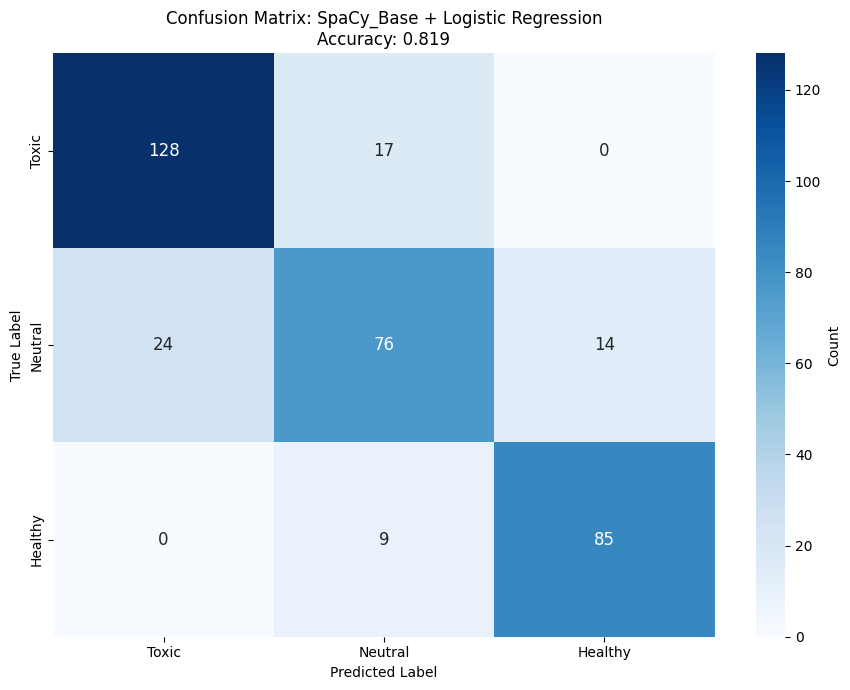

In [244]:
print("🚀 Esecuzione Grid Search: SpaCy Base + Logistic Regression...")
_spacy_base_doc_cache.clear() # Reset cache per evitare leakage tra esperimenti
gs_spacy_base_log = esegui_grid_search_log_reg("SpaCy_Base", Spacy_tokenizer_base)

#### 8.2.2 🧪 Stemming + Logistic Regression 
- (richiede ~4 minuti ~300 campioni di training)
- (richiede ~17 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: Spacy con Stemming + Logistic Regression...

🔍 GRID SEARCH: Spacy con Stemming + Logistic Regression
📊 Testando 162 combinazioni...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

🏆 MIGLIORI PARAMETRI:
   classifier__C: 10.0
   classifier__max_iter: 1000
   tfidf__max_df: 0.99
   tfidf__min_df: 15
   tfidf__ngram_range: (1, 3)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7904
   Test Recall Toxic: 0.8966

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.88      0.90      0.89       145
     Neutral       0.74      0.71      0.72       114
     Healthy       0.83      0.85      0.84        94

    accuracy                           0.82       353
   macro avg       0.82      0.82      0.82       353
weighted avg       0.82      0.82      0.82       353



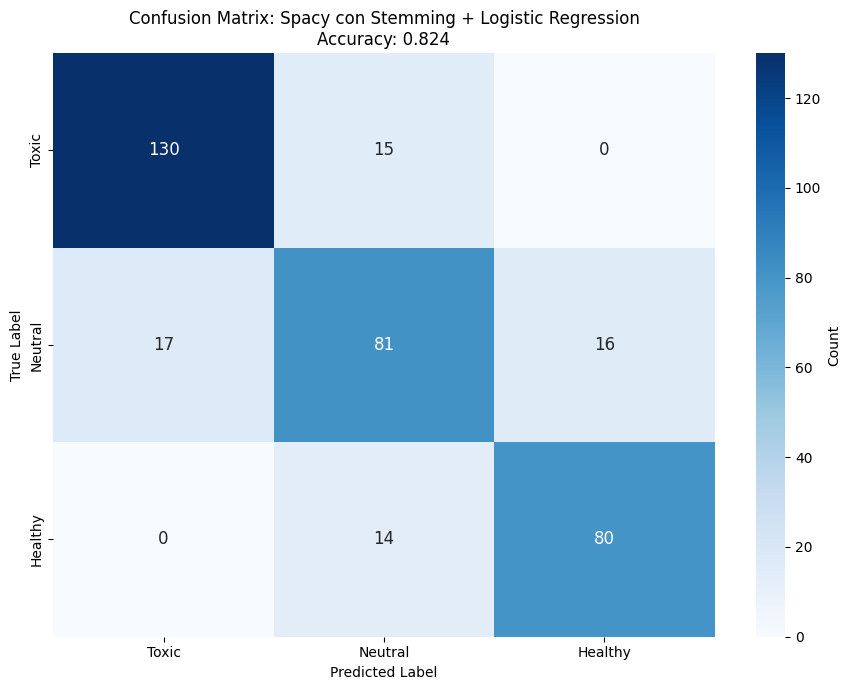

In [245]:
print("🚀 Esecuzione Grid Search: Spacy con Stemming + Logistic Regression...")
_spacy_stemmer_doc_cache.clear()  # Reset cache per evitare leakage tra esperimenti
gs_stemmer_log = esegui_grid_search_log_reg("Spacy con Stemming", Spacy_tokenizer_with_stemming)

#### 8.2.3 🧪 SpaCy Preprocessing + Logistic Regression 
- (richiede ~2.5 minuti ~300 campioni di training)
- (richiede ~8 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: SpaCy Preprocessing + Logistic Regression...

🔍 GRID SEARCH: SpaCy_Preprocessing + Logistic Regression
📊 Testando 162 combinazioni...
Fitting 3 folds for each of 162 candidates, totalling 486 fits

🏆 MIGLIORI PARAMETRI:
   classifier__C: 1.0
   classifier__max_iter: 1000
   tfidf__max_df: 0.9
   tfidf__min_df: 15
   tfidf__ngram_range: (1, 3)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7401
   Test Recall Toxic: 0.8414

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.78      0.84      0.81       145
     Neutral       0.60      0.54      0.57       114
     Healthy       0.80      0.80      0.80        94

    accuracy                           0.73       353
   macro avg       0.73      0.73      0.73       353
weighted avg       0.73      0.73      0.73       353



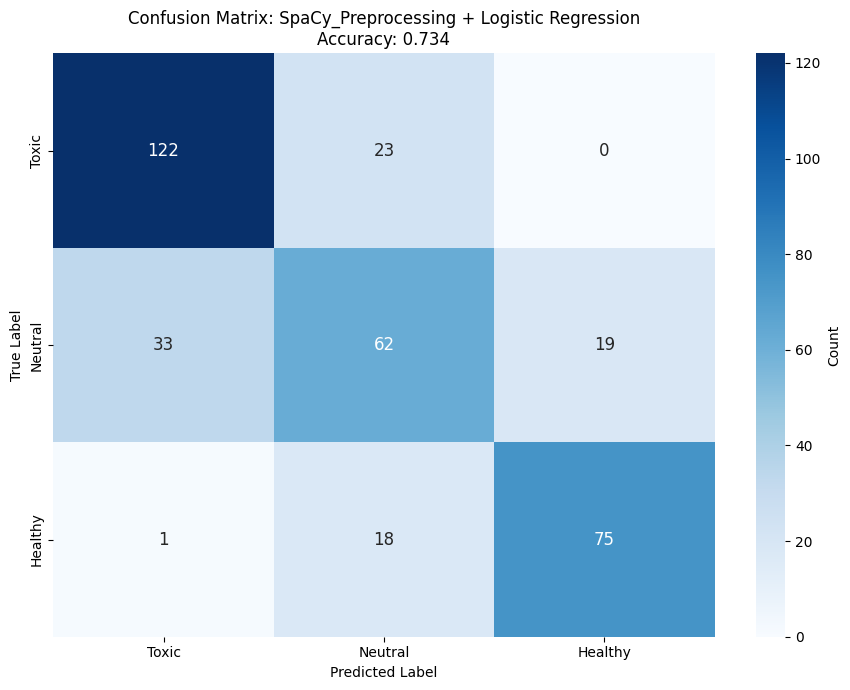

In [246]:
print("🚀 Esecuzione Grid Search: SpaCy Preprocessing + Logistic Regression...")
_spacy_prep_doc_cache.clear() # Reset cache per evitare leakage tra esperimenti
gs_spacy_prep_log = esegui_grid_search_log_reg("SpaCy_Preprocessing", Spacy_tokenizer_with_preprocessing)

### 8.3 Grid Search con Naive Bayes  

#### 8.3.1 🧪 SpaCy Base + Naive Bayes 
- (richiede ~2 minuti ~300 campioni di training)
- (richiede ~6 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: SpaCy Base + Naive Bayes...

🔍 GRID SEARCH: SpaCy_Base + Naive Bayes
📊 Testando 108 combinazioni...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

🏆 MIGLIORI PARAMETRI:
   classifier__alpha: 0.1
   count__max_df: 0.95
   count__min_df: 5
   count__ngram_range: (1, 4)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7606
   Test Recall Toxic: 0.8276

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.88      0.83      0.85       145
     Neutral       0.64      0.68      0.66       114
     Healthy       0.79      0.80      0.79        94

    accuracy                           0.77       353
   macro avg       0.77      0.77      0.77       353
weighted avg       0.78      0.77      0.77       353



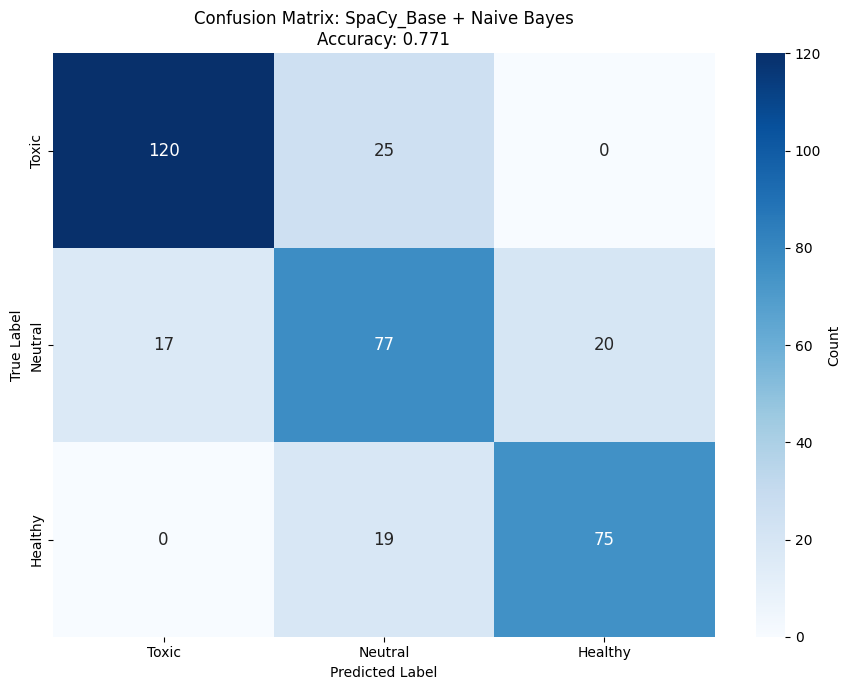

In [247]:
print("🚀 Esecuzione Grid Search: SpaCy Base + Naive Bayes...")
_spacy_base_doc_cache.clear() # Reset cache per evitare leakage tra esperimenti
gs_spacy_base_nb = esegui_grid_search_nb("SpaCy_Base", Spacy_tokenizer_base)

#### 8.3.2 🧪 Stemming + Naive Bayes 
- (richiede ~2.5 minuti ~300 campioni di training)
- (richiede ~11 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: Spacy con Stemming + Naive Bayes...

🔍 GRID SEARCH: Spacy con Stemming + Naive Bayes
📊 Testando 108 combinazioni...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

🏆 MIGLIORI PARAMETRI:
   classifier__alpha: 2.0
   count__max_df: 0.95
   count__min_df: 5
   count__ngram_range: (1, 4)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7684
   Test Recall Toxic: 0.8207

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.84      0.82      0.83       145
     Neutral       0.66      0.61      0.64       114
     Healthy       0.79      0.89      0.84        94

    accuracy                           0.77       353
   macro avg       0.77      0.78      0.77       353
weighted avg       0.77      0.77      0.77       353



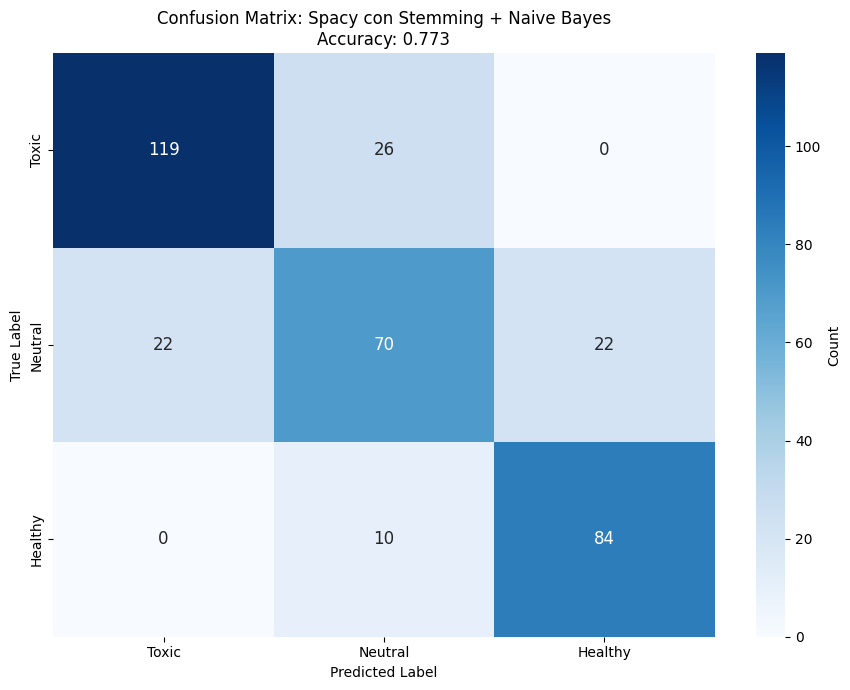

In [248]:
print("🚀 Esecuzione Grid Search: Spacy con Stemming + Naive Bayes...")
_spacy_stemmer_doc_cache.clear()  # Reset cache per evitare leakage tra esperimenti
gs_stemmer_nb = esegui_grid_search_nb("Spacy con Stemming", Spacy_tokenizer_with_stemming)

#### 8.3.3 🧪 SpaCy Preprocessing + Naive Bayes 
- (richiede ~2 minuti ~300 campioni di training)
- (richiede ~6 minuti ~1400 campioni di training)

🚀 Esecuzione Grid Search: SpaCy Preprocessing + Naive Bayes...

🔍 GRID SEARCH: SpaCy_Preprocessing + Naive Bayes
📊 Testando 108 combinazioni...
Fitting 3 folds for each of 108 candidates, totalling 324 fits

🏆 MIGLIORI PARAMETRI:
   classifier__alpha: 0.5
   count__max_df: 0.9
   count__min_df: 5
   count__ngram_range: (1, 3)

📈 PERFORMANCE:
   CV Accuracy (best): 0.7245
   Test Recall Toxic: 0.8000

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Toxic       0.82      0.80      0.81       145
     Neutral       0.59      0.59      0.59       114
     Healthy       0.78      0.82      0.80        94

    accuracy                           0.74       353
   macro avg       0.73      0.74      0.73       353
weighted avg       0.74      0.74      0.74       353



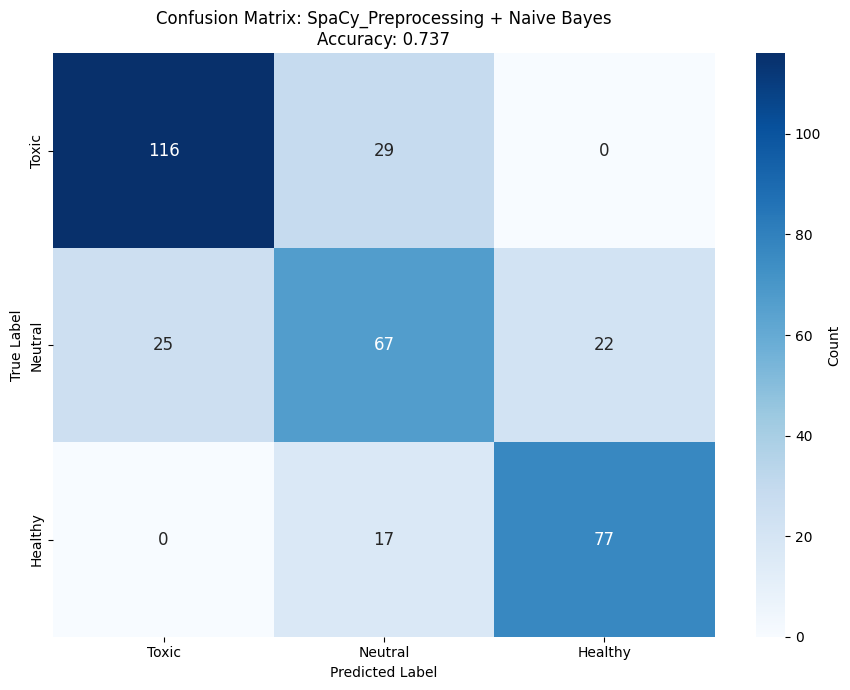

In [249]:
print("🚀 Esecuzione Grid Search: SpaCy Preprocessing + Naive Bayes...")
_spacy_prep_doc_cache.clear() # Reset cache per evitare leakage tra esperimenti
gs_spacy_prep_nb = esegui_grid_search_nb("SpaCy_Preprocessing", Spacy_tokenizer_with_preprocessing)

## 9. Confronto Risultati

In [250]:
# 🏆 Confronto Completo Grid Search
# Esegui questa cella solo dopo aver completato almeno 2 grid search

risultati_grid_search = {}

# Raccogli tutti i risultati disponibili
if 'gs_stemmer_log' in locals():
    risultati_grid_search['Spacy_Stemmer_LogReg'] = gs_stemmer_log
if 'gs_spacy_base_log' in locals():
    risultati_grid_search['SpaCy_Base_LogReg'] = gs_spacy_base_log
if 'gs_spacy_prep_log' in locals():
    risultati_grid_search['SpaCy_Prep_LogReg'] = gs_spacy_prep_log
if 'gs_stemmer_nb' in locals():
    risultati_grid_search['Spacy_Stemmer_NB'] = gs_stemmer_nb
if 'gs_spacy_base_nb' in locals():
    risultati_grid_search['SpaCy_Base_NB'] = gs_spacy_base_nb
if 'gs_spacy_prep_nb' in locals():
    risultati_grid_search['SpaCy_Prep_NB'] = gs_spacy_prep_nb


# Confronta risultati
if len(risultati_grid_search) >= 2:
    confronta_grid_search_results(risultati_grid_search)
else:
    print("⚠️ Esegui almeno 2 grid search prima di confrontare i risultati")

import time


# codice per confrontare i risultati delle grid search nelle varie run

# Salva i risultati delle grid search
if len(risultati_grid_search) >= 2:
    print("💾 Salvataggio risultati grid search...")
    # Salva in un file txt con timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df = risultati_grid_search
    with open(f"../gs_results/grid_search_results_{timestamp}.txt", "w", encoding="utf-8") as f:
        for nome, risultati in results_df.items():
            f.write(f"🔍 {nome}:\n")
            f.write(f"   Migliori Parametri: {risultati['best_params']}\n")
            f.write(f"   CV Accuracy (best): {risultati['best_cv_score']:.4f}\n")
            f.write(f"   Test Recall Toxic: {risultati['test_recall_toxic']:.4f}\n")
            f.write("\n")
    print(f"\n✅ Risultati salvati in: ../gs_results/grid_search_results_{timestamp}.csv")





🏆 CONFRONTO RISULTATI GRID SEARCH
                     CV Accuracy Test Recall Toxic Miglior ngram  \
Spacy_Stemmer_LogReg      0.7904            0.8966        (1, 3)   
SpaCy_Base_LogReg         0.7925            0.8828        (1, 4)   
SpaCy_Prep_LogReg         0.7401            0.8414        (1, 3)   
Spacy_Stemmer_NB          0.7684            0.8207        (1, 4)   
SpaCy_Base_NB             0.7606            0.8276        (1, 4)   
SpaCy_Prep_NB             0.7245            0.8000        (1, 3)   

                     Miglior min_df Miglior max_df  
Spacy_Stemmer_LogReg             15           0.99  
SpaCy_Base_LogReg                 5           0.99  
SpaCy_Prep_LogReg                15            0.9  
Spacy_Stemmer_NB                  5           0.95  
SpaCy_Base_NB                     5           0.95  
SpaCy_Prep_NB                     5            0.9  

🥇 MIGLIOR CONFIGURAZIONE: Spacy_Stemmer_LogReg
🎯 Test Recall Toxic: 0.8966
🔧 Parametri ottimali:
   classifier__C: 1

# Bert: Modello NLP di classificazione

In [20]:
# Importazioni per BERT e Transformers
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from datasets import Dataset
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Verifica disponibilità GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device utilizzato: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM disponibile: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("   ⚠️ CUDA non disponibile, utilizzo CPU (sarà più lento)")

🖥️ Device utilizzato: cuda
   GPU: NVIDIA GeForce RTX 3070
   VRAM disponibile: 8.0 GB


## 🤖 Configurazione BERT Italiano

TODO:
- configurare migliori iperparametri per il fine-tuning
- confrontare i 3 modelli di bert


Utilizziamo un modello BERT pre-addestrato su testi italiani per il fine-tuning sulla classificazione di tossicità.

In [ ]:
# Configurazione modelli BERT italiani disponibili
BERT_MODELS = {
    'roberta-base' : 'FacebookAI/xlm-roberta-base',
    'bert-base-italian': 'dbmdz/bert-base-italian-cased',
    'umberto-base': 'Musixmatch/umberto-commoncrawl-cased-v1'
}

# Scegliamo il modello (iniziamo con quello più semplice)
SELECTED_BERT_MODEL = BERT_MODELS['roberta-base']
print(f"🤖 Modello BERT selezionato: {SELECTED_BERT_MODEL}")

# Configurazioni per il fine-tuning
MAX_LENGTH = 256  # Lunghezza massima sequenza (adatta per chat)
BATCH_SIZE = 16   # Ridotto per evitare OOM
LEARNING_RATE = 2e-5  # Learning rate standard per BERT
NUM_EPOCHS = 10    # Poche epoche per evitare overfitting
NUM_LABELS = 3    # Toxic, Neutral, Healthy

print(f"⚙️ Configurazioni:")
print(f"   Max length: {MAX_LENGTH}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Learning rate: {LEARNING_RATE}")
print(f"   Epochs: {NUM_EPOCHS}")
print(f"   Num labels: {NUM_LABELS}")

🤖 Modello BERT selezionato: FacebookAI/xlm-roberta-base
⚙️ Configurazioni:
   Max length: 256
   Batch size: 16
   Learning rate: 2e-05
   Epochs: 10
   Num labels: 3


### 🔤 Caricamento Tokenizer e Modello BERT

In [22]:
print("🔄 Caricamento tokenizer BERT...")
try:
    tokenizer = AutoTokenizer.from_pretrained(SELECTED_BERT_MODEL)
    print(f"✅ Tokenizer caricato: {tokenizer.__class__.__name__}")
    print(f"   Vocab size: {tokenizer.vocab_size}")
    print(f"   Special tokens: {tokenizer.special_tokens_map}")
except Exception as e:
    print(f"❌ Errore caricamento tokenizer: {e}")
    raise

print("\n🔄 Caricamento modello BERT...")
try:
    model = AutoModelForSequenceClassification.from_pretrained(
        SELECTED_BERT_MODEL,
        num_labels=NUM_LABELS,
        problem_type="single_label_classification"
    )
    model.to(device)
    print(f"✅ Modello caricato: {model.__class__.__name__}")
    print(f"   Parametri totali: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   Parametri trainabili: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
except Exception as e:
    print(f"❌ Errore caricamento modello: {e}")
    raise

# Test veloce del tokenizer
sample_text = "[UNK]Questo è un messaggio di prova per testare il tokenizer BERT italiano! 😊😂 sono emojii 🔥👍💔"
tokens = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True, max_length=MAX_LENGTH)
print(f"\n🧪 Test tokenizer:")
print(f"   Input: {sample_text}")
print(f"   Token IDs: {tokens['input_ids'].squeeze().tolist()}") 
print(f"   Attention mask: {tokens['attention_mask'].squeeze().tolist()}")
print(f"   Tokens decodificati: {tokenizer.decode(tokens['input_ids'].squeeze())}")

🔄 Caricamento tokenizer BERT...
✅ Tokenizer caricato: XLMRobertaTokenizerFast
   Vocab size: 250002
   Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}

🔄 Caricamento modello BERT...
✅ Tokenizer caricato: XLMRobertaTokenizerFast
   Vocab size: 250002
   Special tokens: {'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}

🔄 Caricamento modello BERT...


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Modello caricato: XLMRobertaForSequenceClassification
   Parametri totali: 278,045,955
   Parametri trainabili: 278,045,955

🧪 Test tokenizer:
   Input: [UNK]Questo è un messaggio di prova per testare il tokenizer BERT italiano! 😊😂 sono emojii 🔥👍💔
   Token IDs: [0, 378, 180323, 268, 195136, 31, 565, 51, 120990, 45, 13395, 117, 23261, 107, 211, 47, 1098, 52825, 20080, 618, 38818, 38, 6, 82803, 115114, 1389, 28, 121505, 14, 6, 222326, 118280, 245720, 2]
   Attention mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
   Tokens decodificati: <s> [UNK]Questo è un messaggio di prova per testare il tokenizer BERT italiano! 😊😂 sono emojii 🔥👍💔</s>


### 📊 Preparazione Dataset per BERT

In [23]:
def tokenize_function(examples):
    """Tokenizza i testi per BERT."""
    return tokenizer(
        examples["text"], 
        truncation=True, 
        padding="max_length", # possibile cambiare in 'longest' per padding dinamico
        max_length=MAX_LENGTH
    )

def prepare_bert_dataset(texts, labels):
    """Prepara dataset per BERT training."""
    print(f"📊 Preparazione dataset BERT...")
    print(f"   Numero campioni: {len(texts)}")
    print(f"   Distribuzione labels: {pd.Series(labels).value_counts().sort_index()}")
    
    # Crea dataset Hugging Face
    dataset = Dataset.from_dict({
        "text": texts.tolist() if hasattr(texts, 'tolist') else list(texts),
        "labels": labels.tolist() if hasattr(labels, 'tolist') else list(labels)
    })
    
    # Tokenizza
    print("🔤 Tokenizzazione in corso...")
    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    
    # Rimuovi colonna text (non più necessaria)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"])
    
    print(f"✅ Dataset tokenizzato: {len(tokenized_dataset)} campioni")
    print(f"   Colonne: {tokenized_dataset.column_names}")
    
    return tokenized_dataset

# Prepara i dataset di train e test
print("🚀 Preparazione dataset per BERT...")
bert_train_dataset = prepare_bert_dataset(X_train, y_train)
bert_test_dataset = prepare_bert_dataset(X_test, y_test)

print(f"\n📈 Dataset preparati:")
print(f"   Training: {len(bert_train_dataset)} campioni")
print(f"   Test: {len(bert_test_dataset)} campioni")

# Visualizza un esempio
print(f"\n🔍 Esempio campione tokenizzato:")
sample = bert_train_dataset[0]
print(f"   Input IDs shape: {len(sample['input_ids'])}")
print(f"   Attention mask shape: {len(sample['attention_mask'])}")
print(f"   Label: {sample['labels']} ({TARGET_NAMES[sample['labels']]})")
print(f"   Testo decodificato: {tokenizer.decode(sample['input_ids'][:50])}...")

🚀 Preparazione dataset per BERT...
📊 Preparazione dataset BERT...
   Numero campioni: 1412
   Distribuzione labels: label
0    579
1    456
2    377
Name: count, dtype: int64
🔤 Tokenizzazione in corso...


Map: 100%|██████████| 1412/1412 [00:00<00:00, 4793.90 examples/s]



✅ Dataset tokenizzato: 1412 campioni
   Colonne: ['labels', 'input_ids', 'attention_mask']
📊 Preparazione dataset BERT...
   Numero campioni: 353
   Distribuzione labels: label
0    145
1    114
2     94
Name: count, dtype: int64
🔤 Tokenizzazione in corso...


Map: 100%|██████████| 353/353 [00:00<00:00, 5077.85 examples/s]

✅ Dataset tokenizzato: 353 campioni
   Colonne: ['labels', 'input_ids', 'attention_mask']

📈 Dataset preparati:
   Training: 1412 campioni
   Test: 353 campioni

🔍 Esempio campione tokenizzato:
   Input IDs shape: 256
   Attention mask shape: 256
   Label: 0 (Toxic)
   Testo decodificato: <s> Ciao Elena! Volevo farti sapere che mi sono iscritto a un gruppo di lettura sulla letteratura del Novecento italiano, lo fanno il martedì sera. È una cosa che mi appassiona da morire e sento che mi darà tanti nuovi...


### ⚙️ Configurazione Training BERT

In [24]:
# Funzione per calcolare metriche durante il training
def compute_metrics(eval_pred):
    """Calcola metriche per la valutazione."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calcola metriche standard
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    
    # Calcola recall specifico per la classe Toxic (0)
    recall_toxic = recall_score(labels, predictions, labels=[0], average='macro', zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'recall_toxic': recall_toxic
    }

# Configurazione parametri di training
training_args = TrainingArguments(
    output_dir='./results_bert',          # Directory per salvare i checkpoints
    num_train_epochs=NUM_EPOCHS,         # Numero di epoche
    per_device_train_batch_size=BATCH_SIZE,  # Batch size per training
    per_device_eval_batch_size=BATCH_SIZE,   # Batch size per evaluation
    warmup_steps=100,                     # Warm-up steps
    weight_decay=0.01,                    # Weight decay per regolarizzazione
    learning_rate=LEARNING_RATE,         # Learning rate
    logging_dir='./logs_bert',            # Directory per i log
    logging_steps=50,                     # Log ogni N steps
    eval_strategy="epoch",                # Valuta a ogni epoca
    save_strategy="epoch",                # Salva a ogni epoca
    load_best_model_at_end=True,         # Carica il miglior modello alla fine
    metric_for_best_model="accuracy",    # Metrica per selezionare il miglior modello
    greater_is_better=True,               # Higher accuracy is better
    save_total_limit=2,                   # Mantieni solo i migliori 2 checkpoint
    report_to="none",                     # Disabilita wandb/tensorboard per semplicità
    fp16=torch.cuda.is_available(),       # Mixed precision se GPU disponibile
)

print("⚙️ Configurazione training:")
print(f"   Output directory: {training_args.output_dir}")
print(f"   Epochs: {training_args.num_train_epochs}")
print(f"   Batch size (train): {training_args.per_device_train_batch_size}")
print(f"   Learning rate: {training_args.learning_rate}")
print(f"   Evaluation strategy: {training_args.eval_strategy}")
print(f"   Metric for best model: {training_args.metric_for_best_model}")
print(f"   Mixed precision (fp16): {training_args.fp16}")

# Data collator per gestire padding dinamico
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
print(f"✅ Data collator configurato: {data_collator.__class__.__name__}")

⚙️ Configurazione training:
   Output directory: ./results_bert
   Epochs: 10
   Batch size (train): 16
   Learning rate: 2e-05
   Evaluation strategy: IntervalStrategy.EPOCH
   Metric for best model: accuracy
   Mixed precision (fp16): True
✅ Data collator configurato: DataCollatorWithPadding


### 🚀 Training BERT

**⚠️ Nota**: Il training di BERT può richiedere tempo significativo:
- Con GPU: ~10-30 minuti per 3 epoche
- Con CPU: ~1-3 ore per 3 epoche

Se vuoi fare un test rapido, riduci `NUM_EPOCHS` a 1.

In [25]:
# Inizializza il Trainer
print("🔧 Inizializzazione Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=bert_train_dataset,
    eval_dataset=bert_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print(f"✅ Trainer inizializzato")
print(f"   Modello: {type(trainer.model).__name__}")
print(f"   Training dataset: {len(trainer.train_dataset)} campioni")
print(f"   Eval dataset: {len(trainer.eval_dataset)} campioni")

# Prima di iniziare il training, mostra una valutazione baseline
print("\n📊 Valutazione BASELINE (modello non fine-tuned):")
baseline_metrics = trainer.evaluate()
for key, value in baseline_metrics.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        if isinstance(value, float):
            print(f"   {metric_name}: {value:.4f}")

print(f"\n🚀 Avvio training BERT...")
print(f"   Questo potrebbe richiedere diversi minuti...")
print(f"   Device: {device}")

# Avvia il training
import time
start_time = time.time()

try:
    trainer.train()
    training_time = time.time() - start_time
    print(f"\n✅ Training completato!")
    print(f"   Tempo totale: {training_time/60:.1f} minuti")
    
    # Salva il modello finale
    trainer.save_model("./final_bert_model")
    tokenizer.save_pretrained("./final_bert_model")
    print(f"💾 Modello salvato in: ./final_bert_model")
    
except Exception as e:
    print(f"❌ Errore durante il training: {e}")
    raise

C:\Users\tomma\AppData\Local\Temp\ipykernel_9140\2229606036.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


🔧 Inizializzazione Trainer...
✅ Trainer inizializzato
   Modello: XLMRobertaForSequenceClassification
   Training dataset: 1412 campioni
   Eval dataset: 353 campioni

📊 Valutazione BASELINE (modello non fine-tuned):


c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


   loss: 1.1045
   model_preparation_time: 0.0020
   accuracy: 0.4108
   f1: 0.2392
   precision: 0.1687
   recall: 0.4108
   recall_toxic: 1.0000
   runtime: 1.0591
   samples_per_second: 333.2940
   steps_per_second: 21.7160

🚀 Avvio training BERT...
   Questo potrebbe richiedere diversi minuti...
   Device: cuda


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,F1,Precision,Recall,Recall Toxic
1,1.098700,1.059204,0.002000,0.509915,0.415386,0.609609,0.509915,1.000000
2,0.816500,0.649635,0.002000,0.708215,0.696316,0.705984,0.708215,0.951724
3,0.603400,0.618600,0.002000,0.742210,0.732650,0.741189,0.742210,0.820690
4,0.459300,0.609980,0.002000,0.762040,0.765597,0.775913,0.762040,0.758621
5,0.391600,0.618485,0.002000,0.776204,0.779644,0.788032,0.776204,0.779310
6,0.295200,0.744846,0.002000,0.747875,0.748165,0.751038,0.747875,0.793103
7,0.186200,1.167009,0.002000,0.702550,0.705467,0.739043,0.702550,0.620690
8,0.167100,0.992968,0.002000,0.736544,0.742513,0.757655,0.736544,0.751724
9,0.096000,1.102529,0.002000,0.770538,0.775498,0.788973,0.770538,0.772414
10,0.107400,1.202509,0.002000,0.736544,0.741131,0.752042,0.736544,0.744828



✅ Training completato!
   Tempo totale: 3.8 minuti
💾 Modello salvato in: ./final_bert_model
💾 Modello salvato in: ./final_bert_model


### 📊 Valutazione Finale BERT

📈 Valutazione finale del modello BERT fine-tuned:


   loss: 0.6185
   model_preparation_time: 0.0020
   accuracy: 0.7762
   f1: 0.7796
   precision: 0.7880
   recall: 0.7762
   recall_toxic: 0.7793
   runtime: 1.0741
   samples_per_second: 328.6410
   steps_per_second: 21.4130

🔮 Generazione predizioni sul test set...
📊 Classification Report BERT:
              precision    recall  f1-score   support

       Toxic       0.89      0.78      0.83       145
     Neutral       0.64      0.73      0.68       114
     Healthy       0.81      0.83      0.82        94

    accuracy                           0.78       353
   macro avg       0.78      0.78      0.78       353
weighted avg       0.79      0.78      0.78       353


🔥 Confusion Matrix BERT:
📊 Classification Report BERT:
              precision    recall  f1-score   support

       Toxic       0.89      0.78      0.83       145
     Neutral       0.64      0.73      0.68       114
     Healthy       0.81      0.83      0.82        94

    accuracy                           0.78   

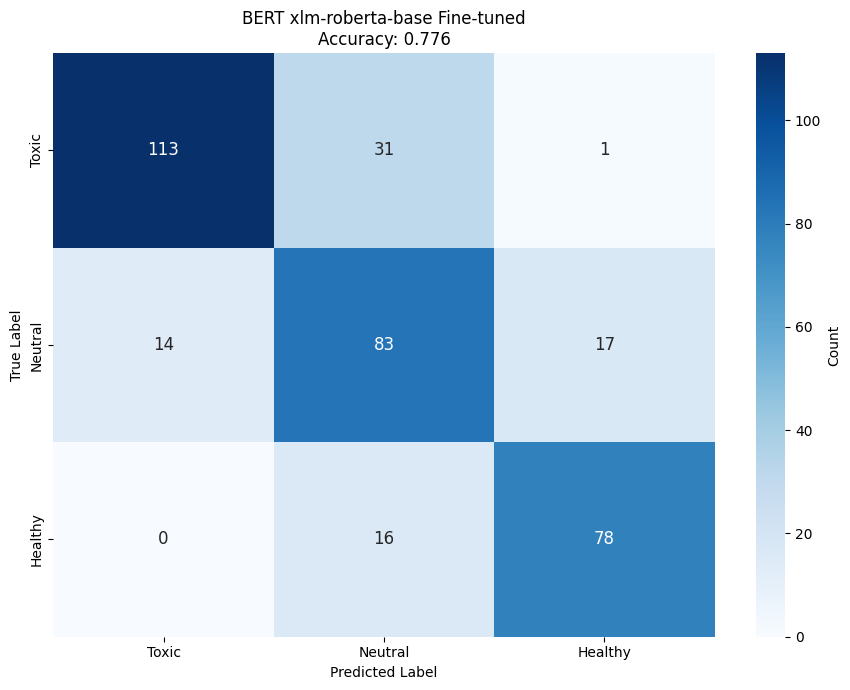


✨ Risultati BERT per confronto:
   Modello utilizzato: FacebookAI/xlm-roberta-base
   Test Accuracy: 0.7762
   Test Recall Toxic: 0.7793
   Test F1-Score: 0.7796
   Configurazione: Epochs=10, LR=2e-05, MaxLen=256

⚠️ Variabile 'risultati_grid_search' non trovata. Esegui prima le Grid Search tradizionali.


In [26]:
# Valutazione finale del modello fine-tuned
print("📈 Valutazione finale del modello BERT fine-tuned:")
final_metrics = trainer.evaluate()

# Estrai e formatta le metriche
bert_results = {}
for key, value in final_metrics.items():
    if key.startswith('eval_'):
        metric_name = key.replace('eval_', '')
        bert_results[metric_name] = value
        if isinstance(value, float):
            print(f"   {metric_name}: {value:.4f}")

# Predizioni sul test set per confusion matrix
print(f"\n🔮 Generazione predizioni sul test set...")
predictions = trainer.predict(bert_test_dataset)
y_pred_bert = np.argmax(predictions.predictions, axis=1)
y_true_bert = predictions.label_ids

print(f"📊 Classification Report BERT:")
print(classification_report(y_true_bert, y_pred_bert, target_names=TARGET_NAMES, zero_division=0))

# Confusion Matrix
print(f"\n🔥 Confusion Matrix BERT:")
plot_confusion_matrix_heatmap(y_true_bert, y_pred_bert, TARGET_NAMES, 
                             title=f"BERT {SELECTED_BERT_MODEL.split('/')[-1]} Fine-tuned")

# Calcola recall toxic manualmente per coerenza con gli altri modelli
test_recall_toxic_manual = recall_score(y_true_bert, y_pred_bert, labels=[0], zero_division=0, average='macro')

# Calcola metriche specifiche per confronto
bert_final_results = {
    'model_type': f'BERT_{SELECTED_BERT_MODEL.split("/")[-1]}',  # Nome specifico del modello
    'best_cv_score': bert_results.get('accuracy', 0.0),  # Accuracy come metrica di selezione
    'test_recall_toxic': test_recall_toxic_manual,  # Calcolata manualmente per coerenza
    'test_accuracy': bert_results.get('accuracy', 0.0),
    'test_f1': bert_results.get('f1', 0.0),
    'y_pred': y_pred_bert,
    'y_test': y_true_bert,
    'best_params': f'model: {SELECTED_BERT_MODEL}, epochs: {NUM_EPOCHS}, lr: {LEARNING_RATE}'
}

print(f"\n✨ Risultati BERT per confronto:")
print(f"   Modello utilizzato: {SELECTED_BERT_MODEL}")
print(f"   Test Accuracy: {bert_final_results['test_accuracy']:.4f}")
print(f"   Test Recall Toxic: {bert_final_results['test_recall_toxic']:.4f}")
print(f"   Test F1-Score: {bert_final_results['test_f1']:.4f}")
print(f"   Configurazione: Epochs={NUM_EPOCHS}, LR={LEARNING_RATE}, MaxLen={MAX_LENGTH}")

# Salva i risultati BERT per confronto con gli altri modelli
if 'risultati_grid_search' in locals():
    risultati_grid_search[f'BERT_{SELECTED_BERT_MODEL.split("/")[-1]}'] = bert_final_results
    print(f"\n✅ Risultati BERT aggiunti per confronto finale!")
    
    # Confronto finale aggiornato con BERT
    print(f"\n🏆 CONFRONTO FINALE CON BERT:")
    confronta_grid_search_results(risultati_grid_search)
else:
    print(f"\n⚠️ Variabile 'risultati_grid_search' non trovata. Esegui prima le Grid Search tradizionali.")